<a href="https://colab.research.google.com/github/bachafaris/machine-learning/blob/main/img_classifcation_and_conversion_to_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binary image classification 
* get data 
* train model
* save model  in  h5 format 
* load model 
* convert model to tflite
* load and predict on tf lite

In [169]:
import os 
import tensorflow as tf

import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, MaxPooling2D,  Dropout,BatchNormalization
from tensorflow.keras.activations import swish

helper functions

In [146]:
def prediction(image_path , model):
  classes= ['Pizza ', 'Steak']
  img = cv.imread(image_path)
  img= cv.resize(img, (128, 128))
  i = np.expand_dims(img, 0)
  i = i/255
  pred= model.predict(i)
  pred_class= classes[int(np.round(pred)[0][0])]
  print(f"model's prediction: {pred}")
  print(f"Prediction:{pred_class}")
  return cv2_imshow(img)

In [147]:
# plot loss and accuracy from model hsitory
 #helper function
def plot_loss_curve(history):
  loss=history.history['loss']
  val_loss= history.history['val_loss']
  accuracy= history.history['accuracy']
  val_accuracy= history.history['val_accuracy']
  epoch= range(len(history.history['loss']))
  plt.figure(figsize=(20,7))
  plt.subplot(1,2,1)
  plt.plot(epoch, loss, label= 'traning_loss')
  plt.plot(epoch, val_loss , label = 'val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.ylabel("losses")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(epoch, accuracy, label= 'accurecy')
  plt.plot(epoch, val_accuracy, label= 'val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()

download data set 

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip


--2023-02-15 06:19:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   141MB/s    in 0.7s    

2023-02-15 06:19:04 (141 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



unzip the dataset

In [ ]:
import zipfile
data = zipfile.ZipFile("pizza_steak.zip", "r")
data.extractall()
data.close()

In [ ]:
# total no images
img_no= 0 
for dirpath, dirnames, fname in os.walk('./pizza_steak/'):
  print(f'there are {len(dirnames)} directoy and  {len(fname)} of image found i {dirpath} ')
  img_no += len(fname)
print(f'total no of image is {img_no}')

there are 2 directoy and  0 of image found i ./pizza_steak/ 
there are 2 directoy and  0 of image found i ./pizza_steak/train 
there are 0 directoy and  750 of image found i ./pizza_steak/train/pizza 
there are 0 directoy and  750 of image found i ./pizza_steak/train/steak 
there are 2 directoy and  0 of image found i ./pizza_steak/test 
there are 0 directoy and  250 of image found i ./pizza_steak/test/pizza 
there are 0 directoy and  250 of image found i ./pizza_steak/test/steak 
total no of image is 2000


In [ ]:
p= Path("/content/pizza_steak")
images= [str(i) for i in p.glob("**/*.jpg")]


In [ ]:
images_name= [i.name for i in p.glob("*/*.jpg")]

shape of the image (512, 512, 3)


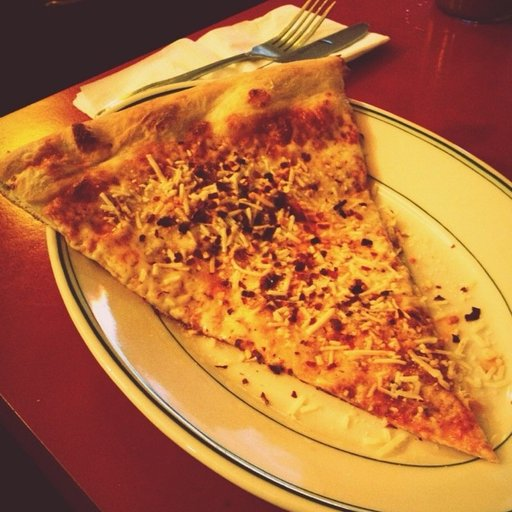

In [ ]:
# img= cv.imread(images[9])
r= np.random.randint(1, 2000)
r_img= cv.imread(images[r])
print(f"shape of the image {r_img.shape}")
cv2_imshow(r_img)
# plt.imshow(r_img)

we can make the batches itsel manually


***methods*** 
* first expand_dims of the images to [1, 240, 240 , 3] and concat axis = 0
* stach the all images of bach size if you want bach size of 10 stack all 10

In [ ]:
# r= np.random.randint(1, 2000)
def read_img(img):
    a= cv.imread(img)
    a= cv.resize(a, (240, 240))
    return a
a= read_img(images[9])
b= read_img(images[87])
c= read_img(images[888])
z= np.stack([a, b, c])
z.shape

(3, 240, 240, 3)

Model traning

In [148]:
train_path= "/content/pizza_steak/train"
save_path= '/content/pizza_steak_data'
test_path= "/content/pizza_steak/test"

In [41]:
import scipy
data_gen= ImageDataGenerator(rescale=1./255)
# if wannt data augmentation 
# data_gen = ImageDataGenerator(rescale=1/255.,
#                                              rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
#                                              shear_range=0.2, # shear the image
#                                              zoom_range=0.2, # zoom into the image
#                                              width_shift_range=0.2, # shift the image width ways
#                                              height_shift_range=0.2, # shift the image height ways
#                                              horizontal_flip=True) # flip the image on the horizontal axis
train_data= data_gen.flow_from_directory(train_path, 
                                    target_size= (128, 128),
                                    batch_size= 32, 
                                    class_mode= 'binary',
                                    shuffle = True, 
                                    seed= 42
                                    # save_to_dir=save_path
                                     ) 

Found 1500 images belonging to 2 classes.


In [ ]:
# classes detect in the data 
train_data.class_indices

{'pizza': 0, 'steak': 1}

In [42]:
data_gen= ImageDataGenerator(rescale=1./255)
test_data= data_gen.flow_from_directory(test_path,
                                        target_size= (128, 128),
                                         batch_size= 32, 
                                        class_mode= 'binary',
                                        # shuffle = True, 
                                        seed= 42)

Found 500 images belonging to 2 classes.


In [38]:
# run this 15 epoch
model= Sequential([
    Conv2D( filters= 16,
           kernel_size= (3,3),
           input_shape= (128, 128,3),
           activation= 'relu'),
           Dropout(0.4),
           MaxPooling2D(3,3),
         
           Conv2D(32, (3,3), activation='relu'),
           Dropout(0.4),
           MaxPooling2D(2,2),
           Conv2D(16, (3,3), activation='relu'),
           Dropout(0.4),
           MaxPooling2D(2,2),
           Flatten(),
           Dense(512, activation='relu'),
           Dropout(.4),
          #  Dense(16, activation='relu'),
          #  Dropout(.4),

           Dense(1, activation='sigmoid')
           ])
# try also on dense 2 node and softmax

In [ ]:
import tensorflow

In [43]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(.0005),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, None, None, 3)    12        
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 8)     224       
                                                                 
 dropout_18 (Dropout)        (None, None, None, 8)     0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, None, None, 8)    0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 16)    1168      
                                                                 
 dropout_19 (Dropout)        (None, None, None, 16)   

A high validation loss and low validation accuracy indicate that the model is not generalizing well to new data, which could be due to overfitting. In this case, the model may be performing well on the training data but not on the validation data, suggesting that it has memorized the training data rather than learned to generalize to new data. This could be due to a variety of factors, such as an overly complex model, insufficient regularization, or a lack of diverse training data. Additionally, incorrect predictions could be due to issues with the model architecture, hyperparameters, or data preprocessing. It may be necessary to adjust these factors and retrain the model to improve its performance.

In [45]:
# model training on augmented data
hsitory= model.fit(train_data,
          epochs= 15,
          steps_per_epoch= len(train_data),
          validation_data= test_data,
          validation_steps= len(test_data)
          )

Epoch 1/15
47/47 [==============================] - 31s 648ms/step - loss: 0.3694 - accuracy: 0.8327 - val_loss: 0.4958 - val_accuracy: 0.8400
Epoch 2/15
47/47 [==============================] - 31s 655ms/step - loss: 0.3495 - accuracy: 0.8467 - val_loss: 0.4971 - val_accuracy: 0.8620
Epoch 3/15
47/47 [==============================] - 32s 674ms/step - loss: 0.3094 - accuracy: 0.8727 - val_loss: 0.4675 - val_accuracy: 0.8780
Epoch 4/15
47/47 [==============================] - 32s 678ms/step - loss: 0.3080 - accuracy: 0.8733 - val_loss: 0.4351 - val_accuracy: 0.8800
Epoch 5/15
47/47 [==============================] - 32s 678ms/step - loss: 0.2847 - accuracy: 0.8893 - val_loss: 0.4516 - val_accuracy: 0.8700
Epoch 6/15
47/47 [==============================] - 33s 685ms/step - loss: 0.2720 - accuracy: 0.8860 - val_loss: 0.4796 - val_accuracy: 0.8540
Epoch 7/15
47/47 [==============================] - 31s 667ms/step - loss: 0.2409 - accuracy: 0.9013 - val_loss: 0.3899 - val_accuracy: 0.8920

also try this

1/1 [==============================] - 0s 58ms/step
model's prediction: [[0.15795074]]
Prediction:Pizza 


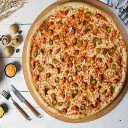

In [149]:
prediction("/content/download (2).jpg", model)

1/1 [==============================] - 0s 34ms/step
model's prediction: [[0.67843705]]
Prediction:Steak


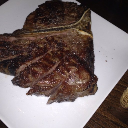

In [152]:
prediction('/content/pizza_steak/test/steak/1190808.jpg', model)

In [ ]:
 # it is overfitting add drop outs
pred= model.evaluate(test_data)

16/16 [==============================] - 4s 215ms/step - loss: 0.3429 - accuracy: 0.8660


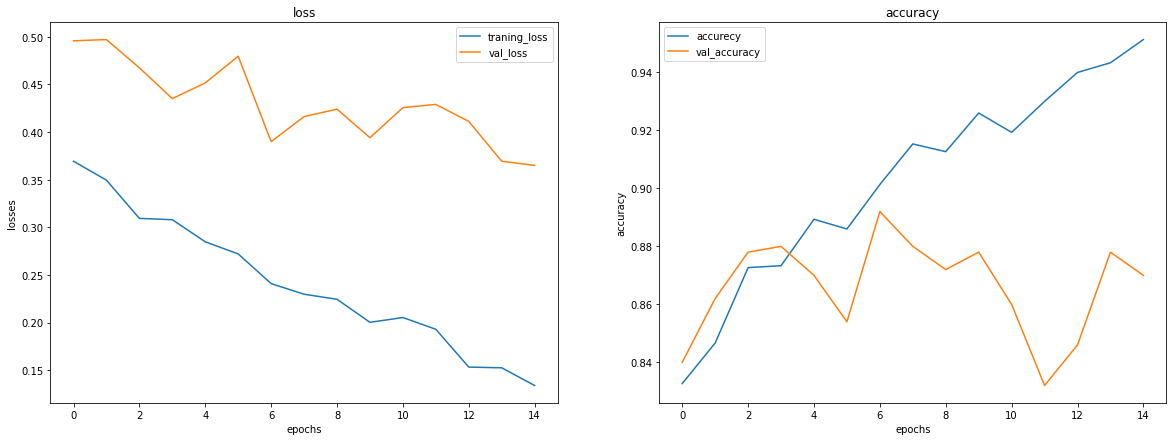

In [51]:
plot_loss_curve(hsitory)

In [ ]:
prediction = model.predict(test_data)

16/16 [==============================] - 5s 256ms/step


1/1 [==============================] - 0s 49ms/step
model's prediction: [[0.0694565]]
Prediction:Pizza 


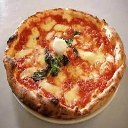

In [155]:
prediction('/content/download (3).jpg', model)

classification report 

In [168]:
# y_true label 
true= test_data.labels

In [159]:
prediction = model.predict(test_data)
prediction = np.round(prediction)
pred= np.squeeze(prediction, -1)

16/16 [==============================] - 5s 259ms/step


In [173]:
target_name= ['pizza', 'steak']
print(classification_report(true, pred, target_names= target_name))

              precision    recall  f1-score   support

       pizza       0.51      0.50      0.50       250
       steak       0.51      0.51      0.51       250

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.51       500
weighted avg       0.51      0.51      0.51       500



In [ ]:
# tf.math.confusion_matrix(
#     true,
#     p,
#     num_classes= ['pizza', 'steak']
#     # weights=None,
#     # dtype=tf.dtypes.int32,
#     # name=None
# )

model saving

In [181]:
tensorflow.keras.models.save_model(model , "model.h5")

loading model 

In [183]:
import tensorflow
loaded_model=tensorflow.keras.models.load_model('/content/model.h5')

loaded model testing

1/1 [==============================] - 0s 167ms/step
model's prediction: [[0.0694565]]
Prediction:Pizza 


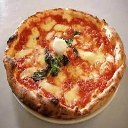

In [191]:
prediction('/content/download (3).jpg', loaded_model)

1/1 [==============================] - 0s 27ms/step
model's prediction: [[0.65346533]]
Prediction:Steak


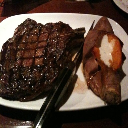

In [192]:
prediction('/content/pizza_steak/test/steak/168551.jpg', loaded_model)


converting model to tflite

In [193]:
# Convert the model to TensorFlow Lite.
# after loading modle
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the converted model to a file.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

prediction on tflite model

In [194]:
import tensorflow as tf
def tflit(model_path, img_path):
  interpreter= tf.lite.Interpreter(model_path=model_path)
  # tensorflow.lite.Interepreter(model_path= model_path)
  interpreter.allocate_tensors()
  input_details= interpreter.get_input_details()
  output_details= interpreter.get_output_details()
  img= cv.imread(img_path)
  img= cv.resize(img, (128, 128))
  i=np.expand_dims(img, 0)
  i= i/255
  i= i.astype('float32')
  interpreter.set_tensor(input_details[0]['index'], i)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]['index'])
  classes= ['Pizza ', 'Steak']
  # print(f"tf lite predicition {output}")
  a= int(np.round(output)[0][0])
  a= np.expand_dims(a, axis = 0)
  # a= np.expand_dims(a, axis = 0)
  print(f" model prediction {a}")
  # print(f"rooung off {np.round(output)[0][0])} " )
  pred= classes[int(np.round(output)[0][0])]
  print(f"tflite model predict : {pred}")
  return cv2_imshow(img)


In [195]:
model_path = '/content/tf_lite_model.tflite'
img_path= '/content/pizza_steak/train/steak/2629750.jpg'

 model prediction [1]
tflite model predict : Steak


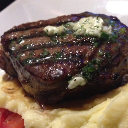

In [196]:
tflit(model_path, img_path)